# Exploring the UTx000 Extension Beacon Data
(See the [GH repo](https://github.com/intelligent-environments-lab/utx000))

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Estimating Ventilation Rates
Using CO$_2$, we can estimate the ventilation rates in the space using various methodologies. 

## Package Import

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Data Import

## Beacon Data
We are primarily concerned with the beacon data when participants are asleep since that is the only time we can be sure participants are home in their bedrooms. However, we also need all the processed beacon data for later.

In [3]:
processed_beacon = pd.read_csv('../data/processed/beacon-ux_s20.csv',
                    index_col="timestamp",parse_dates=True,infer_datetime_format=True)
processed_beacon.head()

,tvoc,lux,no2,co,co2,pm1_number,pm2p5_number,pm10_number,pm1_mass,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap
timestamp,,,,,,,,,,,,,,,,,
2020-06-08 13:00:00,81.2,2.77440,0.775262,13.9663,NaN,11.900343,11.320369,11.075540,0.733881,1.149634,1.935875,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:02:00,82.8,2.77440,0.798162,13.9555,NaN,12.730011,12.184753,11.910685,0.800211,1.198782,1.979986,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:04:00,84.2,2.77440,0.770355,13.8341,NaN,13.183286,12.706129,12.422126,0.840419,1.234695,2.013414,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:06:00,82.0,2.77440,0.780169,14.0344,NaN,12.301532,11.367415,11.062862,0.735991,1.104990,1.886775,27.5,47.00,1,kyj367pi,24,10
2020-06-08 13:08:00,86.6,4.07184,0.781805,13.7661,NaN,12.932402,11.947330,11.611038,0.780179,1.128095,1.905629,27.5,47.05,1,kyj367pi,24,10


In [4]:
beacon = pd.read_csv('../data/processed/beacon-fb_and_gps_filtered-ux_s20.csv',
                    index_col="timestamp",parse_dates=["timestamp","start_time","end_time"],infer_datetime_format=True)
beacon.head()

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,...,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-10 05:10:00,30.58838,-97.42591,113.98145,5.29684,184.700000,2.04,NaN,10.742600,1816.486399,0.145358,...,0.891251,1.901793,24.0,33.183333,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,NaN,NaN,NaN,NaN,164.000000,2.04,NaN,10.678200,1795.248136,0.178794,...,0.903066,1.919541,24.0,33.000000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,NaN,NaN,NaN,NaN,152.433333,2.04,NaN,10.676133,1763.231375,0.186363,...,0.847057,1.861326,24.0,33.000000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,NaN,NaN,NaN,NaN,159.150000,2.04,NaN,10.703900,1724.723961,NaN,...,0.808707,1.833923,24.0,33.050000,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,NaN,NaN,NaN,NaN,143.933333,2.04,NaN,10.667433,1772.028385,1.646941,...,0.947046,1.964887,24.0,32.983333,21,lkkjddam,25,12,2020-08-10 04:42:30,2020-08-10 12:35:30


In [5]:
test = beacon[beacon["beiwe"] == "lkkjddam"]
test[datetime(2020,8,12,13):]

,lat,long,altitude,accuracy,tvoc,lux,no2,co,co2,pm1_number,...,pm2p5_mass,pm10_mass,temperature_c,rh,beacon,beiwe,fitbit,redcap,start_time,end_time
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-08-14 03:05:00,30.58838,-97.42607,153.53619,11.49819,209.950000,0.00,NaN,11.506550,1180.888019,0.108727,...,1.068897,2.096942,23.875000,33.000000,21,lkkjddam,25,12,2020-08-14 03:05:00,2020-08-14 11:23:30
2020-08-14 03:10:00,NaN,NaN,NaN,NaN,220.866667,0.00,NaN,11.739467,1230.804833,1.008604,...,0.908787,1.937580,24.000000,33.000000,21,lkkjddam,25,12,2020-08-14 03:05:00,2020-08-14 11:23:30
2020-08-14 03:15:00,NaN,NaN,NaN,NaN,226.950000,0.00,NaN,11.423750,1189.959631,0.104306,...,0.833094,1.860011,24.000000,33.000000,21,lkkjddam,25,12,2020-08-14 03:05:00,2020-08-14 11:23:30
2020-08-14 03:20:00,NaN,NaN,NaN,NaN,217.966667,0.00,NaN,11.431000,1165.891894,0.186623,...,0.731178,1.750985,24.000000,32.933333,21,lkkjddam,25,12,2020-08-14 03:05:00,2020-08-14 11:23:30
2020-08-14 03:25:00,NaN,NaN,NaN,NaN,222.950000,0.00,NaN,11.511100,1179.294654,NaN,...,0.769117,1.786462,24.000000,33.000000,21,lkkjddam,25,12,2020-08-14 03:05:00,2020-08-14 11:23:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-28 08:35:00,NaN,NaN,NaN,NaN,287.850000,2.04,NaN,7.244850,1704.308458,0.507924,...,1.100101,2.125215,24.500000,35.500000,21,lkkjddam,25,12,2020-08-28 03:41:30,2020-08-28 08:55:30
2020-08-28 08:40:00,NaN,NaN,NaN,NaN,292.733333,2.04,NaN,7.115067,1727.270466,1.122333,...,1.062428,2.064480,24.566667,35.500000,21,lkkjddam,25,12,2020-08-28 03:41:30,2020-08-28 08:55:30
2020-08-28 08:45:00,NaN,NaN,NaN,NaN,294.300000,2.04,NaN,7.124950,1731.523086,3.141985,...,1.263516,2.238732,25.000000,36.125000,21,lkkjddam,25,12,2020-08-28 03:41:30,2020-08-28 08:55:30


## Participant Information
We need the participant beacon, beiwe, and fitbit IDs so we can cross-reference the various pieces of information.

In [26]:
# getting pt names
names = pd.read_excel('../data/raw/utx000/admin/id_crossover.xlsx',sheet_name='all')
names = names[['beiwe','first','last','sex']]
# getting beacon only pts with names
info = pd.read_excel('../data/raw/utx000/admin/id_crossover.xlsx',sheet_name='beacon')
info = info[['redcap','beiwe','beacon','lat','long','volume','roommates']] # keep their address locations
info = info.merge(left_on='beiwe',right=names,right_on='beiwe')
info.head()

,redcap,beiwe,beacon,lat,long,volume,roommates,first,last,sex
0,10.0,kyj367pi,1.0,30.295025,-97.744222,1080.0,0.0,Angela,Gordillo,Female
1,55.0,745vq78e,5.0,30.288012,-97.751201,1188.0,0.0,Olivia,Li,Female
2,61.0,itmylz3g,6.0,29.855371,-95.741200,1188.0,0.0,Rianna,Mendez,Female
3,0.0,zdpffrox,7.0,30.326815,-97.744665,1365.0,1.0,Hagen,Fritz,Male
4,43.0,xlw5ntd5,10.0,30.351693,-97.614524,1188.0,0.0,Katherine,Mai,Female


## Fitbit Data
We will need some information from each of the participants that Fitbit logs like body weight.

In [7]:
daily = pd.read_csv('../data/processed/fitbit-daily-ux_s20.csv',
                   index_col=0,parse_dates=True,infer_datetime_format=True)
daily.head()

,calories,bmr,steps,distance,sedentary_minutes,lightly_active_minutes,fairly_active_minutes,very_active_minutes,calories_from_activities,bmi,fat,weight,food_calories_logged,water_logged,beiwe
timestamp,,,,,,,,,,,,,,,
2020-05-13,2781.0,1876.0,9207,4.396294,1241,70,118,11,1097.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-14,3727.0,1876.0,15207,7.261114,614,263,134,23,2234.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-15,3909.0,1876.0,14556,8.028501,577,205,57,108,2381.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-16,3927.0,1876.0,18453,8.748670,760,176,24,151,2364.0,23.754,0.0,180.0,0.0,0.0,hfttkth7
2020-05-17,4180.0,1876.0,15425,7.973149,605,207,50,131,2652.0,23.754,0.0,180.0,0.0,0.0,hfttkth7


# Ventilation based on constant CO2 concentration
We can estimate the ventilation rate of the participants' bedrooms based on a constant CO2 concentration:

$$
\lambda = \frac{E}{V \left(C - pC_0\right)}
$$

In our case we have to make quite a few assumptions:
- $E$: Emission rate of CO2 can be estimated for humans to be approximately $30 g/hr$. We can further refine this value by considering the height, weight, sex, and activity level of the participant - all information that we have access to. 
- $V$: Arguably the most difficult value to track down and the one that could affect the answer the most. We can assume a volume of each of the participants bedrooms, but there is the possiblility of refining this value by cross-referencing the participants' addresses with any known apartment complexes. From there, we can estimate the floor plan based on the number of roommates.
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- $C_0$: Outdoor concentration of CO2 - another safe assumption of 400 ppm. 

## Emission Rate
Based on an article that Sangeetha sent me, we can determine the emission rate of CO2 from the following equation:

$$
V_{CO_2} = (BMR)(M)(T/P)(0.000179)
$$

where:
- $V_{CO_2}$ is the volumetric emission rate of CO2 in L/s
- $BMR$ is the body mass ratio determined from Persily and De Jonge 2016
- $M$: Activity level in METs
- $T$ is the temperature in Kelvin
- $P$ is the pressure in kPa

### Body Mass Ratio
The body mass ratio is given by one of the two equations since our participants are in the age range of 18-30

$$
BMR_{male} = 0.063m + 2.896\\
BMR_{female} = 0.062m + 2.036
$$

where $m$ is the body mass in kilograms. We have the pariticpants body weights assuming they logged them into Fitbit. We can grab these data and put it alongside the participants beacon, beiwe, and fitbit IDs.

We will take the body weight for each participant, average it over the total amount of time logged (just in case they changed it which I doubt anyone did) and store that value in our ```ventilation_info``` dataframe.

In [29]:
weight_dict = {'beiwe':[],'mass':[]}
for pt in daily['beiwe'].unique():
    daily_pt = daily[daily['beiwe'] == pt]
    weight_dict['beiwe'].append(pt)
    weight_dict['mass'].append(np.nanmean(daily_pt['weight'])*0.453592) # convert to kg
    
mass_info = info.merge(left_on='beiwe',right=pd.DataFrame(weight_dict),right_on='beiwe')
mass_info.head()

,redcap,beiwe,beacon,lat,long,volume,roommates,first,last,sex,mass
0,10.0,kyj367pi,1.0,30.295025,-97.744222,1080.0,0.0,Angela,Gordillo,Female,52.014033
1,55.0,745vq78e,5.0,30.288012,-97.751201,1188.0,0.0,Olivia,Li,Female,53.523856
2,61.0,itmylz3g,6.0,29.855371,-95.741200,1188.0,0.0,Rianna,Mendez,Female,63.502880
3,0.0,zdpffrox,7.0,30.326815,-97.744665,1365.0,1.0,Hagen,Fritz,Male,74.842680
4,43.0,xlw5ntd5,10.0,30.351693,-97.614524,1188.0,0.0,Katherine,Mai,Female,53.070264


In order to properly calculate the BMR of the participants, we need to know whether they are male or female. Participants had to mark whether or not they were male or female on the CRISIS baseline survey we sent via REDCap. 

In [30]:
# getting sex from baseline survey
#crisis_baseline = pd.read_csv('../data/raw/utx000/surveys/CRISIS_E3_labels.csv',
                              #usecols=[0,3],names=['redcap','sex'],header=0)
#sex_info = mass_info.merge(left_on='redcap',right=crisis_baseline,right_on='redcap',how='outer')
#sex_info.dropna(subset=['beacon'],axis=0,inplace=True)
# adding sex manually
#sex_info.iloc[3,-1] = 'Male' # Hagen Fritz
#sex_info.iloc[4,-1] = 'Female' # Katherine Mai
#sex_info.iloc[8,-1] = 'Female' # Elizabeth Avalos
#sex_info.to_csv("~/Desktop/info.csv")

<div class="alert alert-block alert-success">
    
A `sex` column has beend added to the `id_crossover` file so the above cell and import of the CRISIS survey is no longer needed.    
    
</div>

Now we calculate the BMR based on the mass and sex of the participants

In [31]:
def get_BMR(sex, mass):
    '''
    Calculates the BMR based on mass assuming an age range between 18 and 30
    
    Inputs:
    - sex: string in ['Male','Female']
    - mass: double of the mass in kg
    
    Returns BMR from Persily and De Jong 2016
    '''
    if sex.lower() == 'male':
        return 0.063*mass + 2.896
    elif sex.lower() == 'female':
        return 0.062*mass + 2.036
    else:
        return 0

In [40]:
mass_info['bmr'] = mass_info.apply(lambda row: get_BMR(row['sex'],row['mass']),axis=1)
pt_info = mass_info.set_index('beiwe')
pt_info.head()

,redcap,beacon,lat,long,volume,roommates,first,last,sex,mass,bmr
beiwe,,,,,,,,,,,
kyj367pi,10.0,1.0,30.295025,-97.744222,1080.0,0.0,Angela,Gordillo,Female,52.014033,5.260870
745vq78e,55.0,5.0,30.288012,-97.751201,1188.0,0.0,Olivia,Li,Female,53.523856,5.354479
itmylz3g,61.0,6.0,29.855371,-95.741200,1188.0,0.0,Rianna,Mendez,Female,63.502880,5.973179
zdpffrox,0.0,7.0,30.326815,-97.744665,1365.0,1.0,Hagen,Fritz,Male,74.842680,7.611089
xlw5ntd5,43.0,10.0,30.351693,-97.614524,1188.0,0.0,Katherine,Mai,Female,53.070264,5.326356


### Activity Level in METs
The Persily and De Jong 2016 article gives values for activity level in METs dependingon the activity. We can assume that our participants are asleep since we are only using data when Fitbit detects sleeping individuals. The MET value for a sleeping individual, from the article, is **0.95**.

### Temperature
The **temperature will vary depending on the night** that we choose to analyze and therefore will alter the emission rate of CO2. Thus we cannot establish a static emission rate.

### Pressure
The pressure will more or less remain constant since we are at the same altitude for the most part in Austin. The National Weather Service has a [station at the airport](https://w1.weather.gov/data/obhistory/KAUS.html) in Austin that reports the atmopsheric pressure is around **102.5 kPa**.

In [41]:
def get_emission_rate(BMR, T):
    '''
    Calculates the CO2 emission rate
    
    Inputs:
    - BMR: double of body-mass-ratio
    - T: double of Temperature in Kelvin
    
    Returns CO2 emission rate in L/s
    '''
    
    # Assumed constants
    M = 0.95 #METs
    P = 102.5 #kPa
    
    return BMR * M * (T / P) * 0.000179

## Volume
We can always assume a value for the volume of the space, or we can go a bit more in-depth by looking at the addresses of the participants.

Doing this presents their own set of problems since we now have to trust the answers of the participants and the addresses could be different than the addresess we sent the beacons to. Rather, we can simply use average numbers:
- **Stand-Alone Home**: We can use the US average of 11x12 feet with 9 foot ceilings - **1188 feet**
- **Apartment**: Another average value would be 10x12 with 9 foot ceilings - **1080 feet**

<div class="alert-block alert alert-success">
The volume values have already been added to the info.csv file for each participant based on the address used to ship the beacons to, <b>not</b> the response in the EE survey.
<div>

## Outdoor CO2
We can assume the outdoor CO2 concentration is 400 ppm, but we need to convert this value into g/m$^3$.

In [42]:
def convert_ppm_to_gm3(concentration, mm=44.0, mv=24.5):
    '''
    Converts the ppm of a gas to g/m3
    
    Inputs:
    - concentration: double specifying the concentration in ppm
    - mm: double specifying the molar mass of the compound (default is CO2)
    - mv: double of molar volume (default is at room temperature)
    
    Returns concentration in g/m3
    '''
    
    return concentration / 10**6 * mm / mv * 1000

**Testing**

Compare to calculator [here](https://www.teesing.com/en/page/library/tools/ppm-mg3-converter)

In [43]:
convert_ppm_to_gm3(400)

0.7183673469387756

## Constant CO2
Now we need to find periods during the evening when the CO2 concentration is constant. We can do this by looking at the mean difference in CO2 concentration during a certain window. If the change is less than a certain threshold, we can then assume the concentration is stable.

We can also cross-reference with the temperature to make sure that the AC isn't jsut cycling on and off quickly keeping the CO2 within a tight window. 

### Processing Temperature
We want to make sure to use the temperature sensors from the DGS sensors rather than the CO2 sensor. There might be times when one of the temperature sensors is working or they are both operating. In the latter case, we want to average the values and then combine the temperature values into one column.

We will also need the temperature to better estimate the emission rate.

In [44]:
beacon_co2 = beacon[['redcap','beiwe','beacon','fitbit','co2','temperature_c','rh','start_time','end_time']]
beacon_co2.head()

,redcap,beiwe,beacon,fitbit,co2,temperature_c,rh,start_time,end_time
timestamp,,,,,,,,,
2020-08-10 05:10:00,12,lkkjddam,21,25,1816.486399,24.0,33.183333,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:15:00,12,lkkjddam,21,25,1795.248136,24.0,33.000000,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:20:00,12,lkkjddam,21,25,1763.231375,24.0,33.000000,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:25:00,12,lkkjddam,21,25,1724.723961,24.0,33.050000,2020-08-10 04:42:30,2020-08-10 12:35:30
2020-08-10 05:30:00,12,lkkjddam,21,25,1772.028385,24.0,32.983333,2020-08-10 04:42:30,2020-08-10 12:35:30


### CO2 Trend Periods
The function below gets the periods of a certain trends for CO2: increasing, decreasing, or constant (within a threshold).

In [45]:
def get_co2_periods(df, window=12, co2_threshold=10, t_threshold=0.25, time_threshold=300, change='decrease'):
    '''
    Finds and keeps periods of CO2 change or consistency
    
    Inputs:
    - df: Dataframe holding the measured CO2 concentrations at 5-minute timestamps
    - window: integer specifying how many timesteps the increase/decrease has to last
    
    Returns dataframe with only increasing/decreasing periods greater in length than the window time periods
    '''
    # getting differences
    df['change'] = df['co2'] - df['co2'].shift(1)
    df['change'] = df['change'].shift(-1)
    
    df['t_change'] = df['temperature_c'] - df['temperature_c'].shift(1)
    df['t_change'] = df['t_change'].shift(-1)
    
    df["time"] = df.index
    df['dtime'] = df["time"] - df["time"].shift(1)
    df['dtime'] = df['dtime'].shift(-1)
    # find periods of increase/decrease and giving them unique labels
    i = 0
    periods = []
    period = 1
    if change == 'decrease':
        while i < len(df):
            while df['change'][i] < 0 and df['t_change'][i] <= 0 and df['dtime'][i].total_seconds() <= time_threshold:
                periods.append(period)
                i += 1

            periods.append(0)
            period += 1
            i += 1
    elif change == 'increase':
        while i < len(df):
            while df['change'][i] > 0 and abs(df['t_change'][i]) <= t_threshold and df['dtime'][i].total_seconds() <= time_threshold:
                periods.append(period)
                i += 1

            periods.append(0)
            period += 1
            i += 1
    else: # constant periods
        while i < len(df):
            while abs(df['change'][i]) < co2_threshold and df['t_change'][i] <= 0 and df['dtime'][i].total_seconds() <= time_threshold:
                periods.append(period)
                i += 1

            periods.append(0)
            period += 1
            i += 1
        
    # removing periods shorter than the window
    df['period'] = periods
    df = df[df['period'] > 0]
    for period in df['period'].unique():
        temp = df[df['period'] == period]
        if len(temp) < window:
            df = df[df['period'] != period]
            
    return df

## Air Exchange Rate
Now we have all the information we need for the equation, we can determine the air exchange rate in each of the participants' homes.

We do need to find some extra information to convert our units:
- **Density of CO2 ($\rho_{CO_2}$)**: The density of CO2 can be found [here](www.engineeringtoolbox.com/carbon-dioxide-density-specific-weight-temperature-pressure-d_2018.html). We want to look for nearly atmospheric pressure and room temperature.
- **Conversions**: Like cubic feet to cubic meters, ppm to g/m$^3$, and the like.

In [46]:
def get_ach_from_constant_co2(E, V, C, C0=400.0, p=1.0):
    '''
    Calculates the air exchange rate for constant CO2 events
    
    Inputs:
    - E: double of emission rate in L/s
    - V: double of volume in ft3
    - C: double of room co2 concetration in ppm
    - C0: double of outdoor co2 concentration in ppm (default is 400)
    - p: double of penetration factor (default is 1)
    
    Returns ach in 1/h
    '''
    # defining constants
    rho = 1.8 # g/L 
    
    # converting units
    E_gs = E * rho # L/s to g/s
    V_m3 = V * 0.0283168 # ft3 to m3
    C_gm3 = convert_ppm_to_gm3(C) # ppm to g/m3
    C0_gm3 = convert_ppm_to_gm3(C0) # ppm to g/m3
    
    return E_gs / (V_m3 * (C_gm3 - p*C0_gm3)) * 3600

## Calculating emission rates and ventilation rates
Putting everything together now we loop through each night for each participant, calculate the emission rate, and then determine the ventilation rate.

In [47]:
ventilation_df = pd.DataFrame()
for pt in beacon_co2['beiwe'].unique(): # cycling through each of the participants
    # setting up the dictionary to add pt values to
    pt_dict = {'beiwe':[],'beacon':[],'start':[],'end':[],'co2_mean':[],'co2_delta':[],'temperature_c_mean':[],'temperature_c_delta':[],'e':[],'ach':[]}
    # pt-specific dataframes
    beacon_pt = beacon_co2[beacon_co2['beiwe'] == pt]
    info_pt = pt_info[pt_info.index == pt]
    
    for start, end in zip(beacon_pt['start_time'].unique(),beacon_pt['end_time'].unique()): # looping through sleep events
        beacon_pt_night = beacon_pt[start:end] # masking for iaq data during sleep
        if len(beacon_pt_night) > 36: # looking for nights when we have at least 3 hours (beacon data is at 5-min)
            constant_periods = get_co2_periods(beacon_pt_night[['co2','temperature_c','rh']],window=12,change='constant')
            n = len(constant_periods)
            if n > 0:
                C = 0
                dC = 0
                T = 0
                dT = 0
                for period in constant_periods['period']:
                    constant_by_period = constant_periods[constant_periods['period'] == period]
                    if np.nanmean(constant_by_period['co2']) >= 600:
                        C += np.mean(constant_by_period['co2'])
                        dC += np.nanmean(constant_by_period['change'])

                        T += np.mean(constant_by_period['temperature_c'])
                        dT += np.mean(constant_by_period['t_change'])
                
                C /= n
                dC /= n
                T /= n
                dT /= n
                if C > 400:
                    pt_dict['beiwe'].append(pt)
                    pt_dict['beacon'].append(info_pt['beacon'].values[0])
                    pt_dict['start'].append(start)
                    pt_dict['end'].append(end)
                    
                    pt_dict['co2_mean'].append(C)
                    pt_dict['co2_delta'].append(dC)

                    pt_dict['temperature_c_mean'].append(T)
                    pt_dict['temperature_c_delta'].append(dT)

                    E = get_emission_rate(pt_info.loc[pt,'bmr'],T+273)
                    pt_dict['e'].append(E)

                    V = info_pt['volume'].values[0]
                    ACH = get_ach_from_constant_co2(E,V,C)
                    pt_dict['ach'].append(ACH)
        
    ventilation_df = ventilation_df.append(pd.DataFrame(pt_dict))
                

# Volume based on CO2 growth
While not a good estimate, we can use periods of uniterrupted CO2 concentration increases to estimate what the volume of the space might be. Under these conditions, we might assume the the contribution from outdoors is negligible and we simply have accumulation:

$$
V \frac{dC}{dt} = E
$$

## Estimating volume
We can rearrange the original equation to solve for the volume. We have to use our previously defined function to estimate the emission rate from a person though.

In [48]:
def get_volume(df,E,n_people=1):
    '''
    Estimates the volume based on the CO2 emission rate and negligible infiltration/exfiltration
    
    Inputs:
    - df: Dataframe indexed by time holding the CO2 and temperature values over an increasing period of CO2
    - E: double of emission rate of CO2 in L/s
    - n_people: integer specifying the number of CO2 emitters - default is 1 person
    
    Returns the volume in m3 and ft3
    '''
    
    # defining constants
    rho = 1.8 # g/L 
    
    # converting units
    E_gs = E * rho # L/s to g/s
    df['c'] = convert_ppm_to_gm3(df['co2']) # ppm to g/m3
    
    # Calculating
    V_si = (E_gs * (df.index[-1] - df.index[0]).total_seconds()) / (df['c'][-1] - df['c'][0])
    V_ip = V_si / 0.0283168
    return V_si, V_ip

## Calculating volumes for individuals

In [49]:
v_df = pd.DataFrame()
for pt in beacon_co2['beiwe'].unique():
    v_dict = {'beiwe':[],'beacon':[],'start':[],'end':[],'starting_co2':[],'co2_delta':[],'ending_co2':[],'R^2':[],'volume_est':[],'volume_gen':[]}
    # getting pt-specific data
    beacon_co2_pt = beacon_co2[beacon_co2['beiwe'] == pt]
    info_pt = pt_info[pt_info.index == pt]
    # getting co2 periods of increase
    increasing_co2 = get_co2_periods(beacon_co2_pt,window=8,change='increase')
    for period in increasing_co2['period'].unique():
        increasing_period_pt = increasing_co2[increasing_co2['period'] == period]
        T = np.nanmean(increasing_period_pt['temperature_c'])
        E = get_emission_rate(pt_info.loc[pt,'bmr'],T+273)
        V_gen = info_pt['volume'].values[0]
        V_est = get_volume(increasing_period_pt,E)[1]
        # Checking linearity
        Y = increasing_period_pt['co2']
        X = np.arange(0,len(increasing_period_pt)*5,5)
        X = sm.add_constant(X)
        model = sm.OLS(Y,X)
        results = model.fit()
        # adding information to dict
        for key, value_to_add in zip(v_dict.keys(),[pt,info_pt['beacon'].values[0],
                                                  increasing_period_pt.index[0],increasing_period_pt.index[-1],
                                                  increasing_period_pt['co2'][0],
                                                  increasing_period_pt['co2'][-1]-increasing_period_pt['co2'][0],
                                                  increasing_period_pt['co2'][-1],
                                                  results.rsquared,V_est,V_gen]):
            v_dict[key].append(value_to_add)
            
    v_df = v_df.append(pd.DataFrame(v_dict))
    
# Removing bad values
v_df = v_df[v_df['R^2'] > 0.99]
v_df = v_df[v_df['volume_est'] < 10000]
# Averaging
v_df_averaged = v_df.groupby('beiwe').mean()

In [50]:
v_df_averaged

,beacon,starting_co2,co2_delta,ending_co2,R^2,volume_est,volume_gen
beiwe,,,,,,,
745vq78e,5.0,1451.847714,81.719020,1533.566734,0.993478,4134.957692,1188.0
9jtzsuu8,15.0,1131.673041,87.976854,1219.649895,0.994215,3723.146123,1188.0
awa8uces,26.0,1160.536355,119.307470,1279.843825,0.994537,2624.309650,1188.0
e73a1pd5,16.0,3730.768022,269.295724,4000.063746,0.997226,1133.778752,1080.0
lkkjddam,21.0,1575.424075,271.630809,1847.054883,0.995495,2028.756316,1188.0
olaxadz5,38.0,934.956772,131.070766,1066.027538,0.993982,1948.948031,1188.0
qh34m4r9,19.0,883.068285,116.723549,999.791834,0.995913,2602.898147,1188.0
tlmlq19s,36.0,958.755394,176.337907,1135.093301,0.996512,2181.112353,1188.0
tmexej5v,29.0,898.041527,144.811098,1042.852625,0.993686,1561.369612,1188.0


# Ventilation based on CO2 decay
We can estimate the ventilation rate of the participants' bedrooms based on a decay in the CO2 concentration:

$$
C_t = C_{t=0}e^{-\lambda t} + \left(pC_0 + \frac{E}{\lambda V}\right)\left(1 - e^{-\lambda t}\right)
$$

The benefit of this approach is that the exchange rate we get might be agnostic to the accuracy of the sensor assuming the sensor is precise (just off from the true value by a constant difference).

Many of the variables from the previous analysis show up here again which is nice since we already found those. 
- $C_t$: CO2 concentation at some time, $t$
- $C_{t=0}$: CO2 concentration at the beginning of the analysis period
- $E$: Emission rate of CO2 estimated from the Persily and Jonge (2016) paper which looks at the activity, sex, and BMR of the participant. 
- $V$: We opted for a more generic value rather than diving too deep.
- $\lambda$: air exchange rate
- $p$: Penetration factor of CO2 from outside into the indoor space - we can safely assume this to be 1.
- $C_0$: Outdoor concentration of CO2 - another safe assumption of 400 ppm. 

There are two challenges with this approach:
1. What data do we need and from what time?
1. How do we identify periods of CO2 decay?
2. The solution involves an iterative approach since we cannot easily solve for the air exchange rate, $\lambda$

## Occupant still in the space
If we do not assume that the participant left the space, we can directly apply the above equation. We had to go through a similar process we did when estimating the air exchange rate based on a constant CO2 concentration i.e. we need the emission rate and the volume of the space. 

## Occupant leaves
If the participant leaves the bedroom, we don't have any emission sources. Therefore, our equation simplifies to:

$$
C_t = C_{t=0}e^{-\lambda t} + pC_0\left(1 - e^{-\lambda t}\right)
$$

## Occupant leaves and no outdoor penetration
By not considering any outdoor penetration, we can further simplify our equation:

$$
C_t = C_{t=0}e^{-\lambda t}
$$

## New Beacon Data - Wake up periods
We need to grab a different set of beacon data to do this assessment. Instead of looking at CO2 data during the evening, we actually need the CO2 data for a few hours right AFTER the participants woke up. We should be able to easily do this by looking at the stop times from the filtered beacon data and parsing out timestamps for the few hours after this from the processed beacon data.

In [51]:
def get_morning_beacon_data(night_df,all_df,num_hours=3):
    '''
    Grabs beacon data for hours after the participant has woken up.
    
    Inputs:
    - night_df: dataframe holding the nightly measured beacon values
    - all_df: dataframe holding all the beacon measured values
    - num_hours: number of hours after waking up to consider - default is 3
    
    Returns a dataframe of beacon values for the "morning"
    '''
    df = pd.DataFrame()
    for pt in night_df['beiwe'].unique():
        # pt-specific data
        night_pt = night_df[night_df['beiwe'] == pt]
        beacon_pt = all_df[all_df['beiwe'] == pt]
        for wake_time in night_pt['end_time'].unique():
            temp = beacon_pt[wake_time:pd.to_datetime(wake_time)+timedelta(hours=num_hours)]
            temp['start_time'] = wake_time
            df = df.append(temp)
    
    return df

Now we use the functioned we defined above, get combined T/RH columns, and remove unecessary columns.

In [52]:
morning_beacon = get_morning_beacon_data(beacon,processed_beacon)
morning_beacon_co2 = morning_beacon[['redcap','beiwe','beacon','fitbit','co2','temperature_c','rh','start_time']]
morning_beacon_co2.head()

,redcap,beiwe,beacon,fitbit,co2,temperature_c,rh,start_time
timestamp,,,,,,,,
2020-08-10 12:36:00,12,lkkjddam,21,25,1366.844212,24.0,35.0,2020-08-10 12:35:30
2020-08-10 12:38:00,12,lkkjddam,21,25,1372.777309,24.0,35.0,2020-08-10 12:35:30
2020-08-10 12:40:00,12,lkkjddam,21,25,1355.810021,24.0,35.0,2020-08-10 12:35:30
2020-08-10 12:42:00,12,lkkjddam,21,25,1343.411919,24.0,35.0,2020-08-10 12:35:30
2020-08-10 12:44:00,12,lkkjddam,21,25,1347.467790,24.0,35.0,2020-08-10 12:35:30


## Identifying periods of decay
To determine periods of decay we can recycle a lot of the work we did for the growth periods, but just look at the reverse situation. 

The code is actually so similar, that all is required is a switch of the inequality. Therefore, we just need to call the function ```get_co2_periods()``` with ```change = 'decreasing'```.

In [53]:
decay_co2 = get_co2_periods(morning_beacon_co2, window=6, change='decrease')
decay_co2.head()

,redcap,beiwe,beacon,fitbit,co2,temperature_c,rh,start_time,change,t_change,time,dtime,period
timestamp,,,,,,,,,,,,,
2020-08-10 13:42:00,12,lkkjddam,21,25,1469.945094,24.0,35.75,2020-08-10 12:35:30,-6.439194,0.0,2020-08-10 13:42:00,0 days 00:02:00,21
2020-08-10 13:44:00,12,lkkjddam,21,25,1463.505900,24.0,36.00,2020-08-10 12:35:30,-21.640196,0.0,2020-08-10 13:44:00,0 days 00:02:00,21
2020-08-10 13:46:00,12,lkkjddam,21,25,1441.865704,24.0,35.25,2020-08-10 12:35:30,-22.584942,0.0,2020-08-10 13:46:00,0 days 00:02:00,21
2020-08-10 13:48:00,12,lkkjddam,21,25,1419.280762,24.0,35.00,2020-08-10 12:35:30,-20.844063,0.0,2020-08-10 13:48:00,0 days 00:02:00,21
2020-08-10 13:50:00,12,lkkjddam,21,25,1398.436698,24.0,35.00,2020-08-10 12:35:30,-21.257528,0.0,2020-08-10 13:50:00,0 days 00:02:00,21


### Further refining the periods of decay
We are looking for the air exchange rate, so we need to make sure the AC is running during these decay periods. We can do so by looking at the temperature. Therefore we can further restrict our dataframe.

In [54]:
def get_change_T_periods(df, window=6,change='decrease'):
    '''
    Finds and keeps periods of T change
    
    Inputs:
    - df: Dataframe holding the measured T concentrations at 5-minute timestamps
    - window: integer specifying how many timesteps the increase/decrease has to last
    
    Returns dataframe with only increasing/decreasing periods greater in length than the window time periods
    '''
    # getting difference
    df['temperature_change'] = df['temperature_c'] - df['temperature_c'].shift(1)
    df['temperature_change'] = df['temperature_change'].shift(-1)
    # find periods of increase/decrease and giving them unique labels
    i = 0
    periods = []
    period = 1
    if change == 'decrease':
        while i < len(df):
            while df['temperature_change'][i] <= 0:
                periods.append(period)
                i += 1

            periods.append(0)
            period += 1
            i += 1
    else: #increase
        while i < len(df):
            while df['temperature_change'][i] >= 0:
                periods.append(period)
                i += 1

            periods.append(0)
            period += 1
            i += 1
        
    # removing periods shorter than the window
    df['temperature_period'] = periods
    df = df[df['temperature_period'] > 0]
    for period in df['temperature_period'].unique():
        temp = df[df['temperature_period'] == period]
        if len(temp) < window:
            df = df[df['temperature_period'] != period]
            
    return df

The above function helps us identify periods when the temperature is constant and/or increasing/decreasing. We can use the periods to further restrict our co2 decay dataset.

## Iteratively solving for ventilation rate
Now that we can get the periods of decreasing CO2 concentration, we can use the dynamic solution and continuously vary the air exchange rate until we get the lowest error between the measured and estimated concentrations at $t > 0$.

In [55]:
def get_ach_from_dynamic_co2(df, E, V, C0=400.0, p=1.0, plot=False):
    '''
    Calculates the ACH based on a dynamic solution to the mass balance equation
    
    Inputs:
    - df: dataframe indexed by time with CO2 column for CO2 measurements in ppm
    - E: double of emission rate in L/s
    - V: double of volume in ft3
    - C0: double of outdoor co2 concentration in ppm (default is 400)
    - p: double of penetration factor (default is 1)
    
    Returns ach in 1/h
    '''
    # defining constants
    rho = 1.8 # g/L 
    
    # converting units
    E_gh = E * rho *3600 # L/s to g/h
    V_m3 = V * 0.0283168 # ft3 to m3
    df['c'] = convert_ppm_to_gm3(df['co2']) # ppm to g/m3
    C0_gm3 = convert_ppm_to_gm3(C0) # ppm to g/m3
    
    C_t0 = df['c'][0]
    min_rmsd = math.inf
    ach = -1
    C_to_plot = df['c'].values
    for ell in np.arange(0,20.01,0.001):
        Cs = []
        for i in range(len(df)):
            t = i*300/3600
            Cs.append(C_t0 * math.exp(-ell*t) + (p*C0_gm3 - E_gh/(V_m3*ell))*(1 - math.exp(-ell*t)))
            
        rmsd = 0
        for C_est, C_meas in zip(Cs,df['c']):
            rmsd += (C_est-C_meas)**2
        
        rmsd = math.sqrt(rmsd/len(Cs))
        if rmsd < min_rmsd:
            min_rmsd = rmsd
            ach = ell
            C_to_plot = Cs
            
    # Plotting to compare results if flag turned on
    if plot:
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(df.index,df['c'],color='seagreen',label='Measured')
        ax.plot(df.index,C_to_plot,color='firebrick',label=f'ACH={round(ach,2)}; RMSD={round(rmsd,3)}')

        for i in range(len(Cs)):
            ax.annotate(str(round(df['c'].values[i],3)),(df.index[i],df['c'].values[i]))
            ax.annotate(str(round(C_to_plot[i],3)),(df.index[i],C_to_plot[i]))
            
        ax.legend(bbox_to_anchor=(0,1))
        ax2 = ax.twinx()
        ax2.plot(df.index,df['temperature_c'],color='cornflowerblue',label='Temperature')
        ax2.set_ylim([20,30])
        ax2.plot()
        ax2.legend(bbox_to_anchor=(1,1))

        plt.show()
        plt.close()
        
    return ach, min_rmsd, C_to_plot

<div class="alert-block alert alert-warning">
    <p>The above code could use some upgrades in terms of computation time as well as the method used to check how close the solution is. However, it seems to do the trick as of right now.</p>
</div>

## Calculating ventilation rate based on decay
We can use the above equations to test and check what the ventilation rate must be under various conditions. 
Here we go through the three different equations (starting bottom to top) to understand how the ventilation rate changes based on our assumptions.

In [56]:
# some parameters for all three cases:
window = 12
min_co2 = 600
plotting = False

### Occupant leaves and no outdoor CO2 penetration
The most simple case we have: basic decay equation.

In [57]:
decay_eq3_df = pd.DataFrame()
for pt in beacon_co2['beiwe'].unique():
    decay_dict = {'beiwe':[],'beacon':[],'start':[],'end':[],'ending_co2_meas':[],'ending_co2_calculated':[],'rmsd':[],'ach':[]}
    # getting pt-specific data
    beacon_co2_pt = morning_beacon_co2[morning_beacon_co2['beiwe'] == pt]
    info_pt = pt_info[pt_info.index == pt]
    # getting 
    decreasing_co2_ac_pt = get_co2_periods(beacon_co2_pt,window=window,change='decrease')
    #decreasing_co2_ac_pt = get_change_T_periods(decreasing_co2_pt)
    for period in decreasing_co2_ac_pt['period'].unique():
        decreasing_period_ac_pt = decreasing_co2_ac_pt[decreasing_co2_ac_pt['period'] == period]
        if np.nanmin(decreasing_period_ac_pt['co2']) >= min_co2:
            T = np.nanmean(decreasing_period_ac_pt['temperature_c'])
            E = 0
            V = info_pt['volume'].values[0]
            ach, ss, C_est = get_ach_from_dynamic_co2(decreasing_period_ac_pt,E,V,p=0,plot=plotting)
            print(f'{pt}: period {period}')
            # adding information to dict
            for key, value_to_add in zip(decay_dict.keys(),[pt,info_pt['beacon'].values[0],
                                                      decreasing_period_ac_pt.index[0],decreasing_period_ac_pt.index[-1],
                                                      decreasing_period_ac_pt['c'][-1],C_est[-1],
                                                      ss,ach]):
                decay_dict[key].append(value_to_add)
            
    decay_eq3_df = decay_eq3_df.append(pd.DataFrame(decay_dict))
    

lkkjddam: period 133
lkkjddam: period 236
lkkjddam: period 306
lkkjddam: period 389
lkkjddam: period 408
lkkjddam: period 534
lkkjddam: period 563
lkkjddam: period 580
qh34m4r9: period 109
qh34m4r9: period 280
qh34m4r9: period 423
qh34m4r9: period 452
qh34m4r9: period 587
qh34m4r9: period 630
qh34m4r9: period 862
qh34m4r9: period 918
qh34m4r9: period 927
qh34m4r9: period 1155
qh34m4r9: period 1446
qh34m4r9: period 1454
qh34m4r9: period 1633
qh34m4r9: period 1636
qh34m4r9: period 1992
tmexej5v: period 56
tmexej5v: period 85
tmexej5v: period 129
tmexej5v: period 256
tmexej5v: period 358
tmexej5v: period 604
tmexej5v: period 657
tmexej5v: period 670
tmexej5v: period 782
tmexej5v: period 806
tmexej5v: period 908
tmexej5v: period 1156
tmexej5v: period 1189
tmexej5v: period 1281
tmexej5v: period 1531
tmexej5v: period 1629
xlw5ntd5: period 23
xlw5ntd5: period 145
xlw5ntd5: period 191
xlw5ntd5: period 192
xlw5ntd5: period 244
xlw5ntd5: period 313
xlw5ntd5: period 315
xlw5ntd5: period 320
xlw5n

### Occupant leaves 
Now we add in some penetration from outdoors

In [58]:
decay_eq2_df = pd.DataFrame()
for pt in beacon_co2['beiwe'].unique():
    decay_dict = {'beiwe':[],'beacon':[],'start':[],'end':[],'ending_co2_meas':[],'ending_co2_calculated':[],'rmsd':[],'ach':[]}
    # getting pt-specific data
    beacon_co2_pt = morning_beacon_co2[morning_beacon_co2['beiwe'] == pt]
    info_pt = pt_info[pt_info.index == pt]
    # getting 
    decreasing_co2_ac_pt = get_co2_periods(beacon_co2_pt,window=window,change='decrease')
    #decreasing_co2_ac_pt = get_change_T_periods(decreasing_co2_pt)
    for period in decreasing_co2_ac_pt['period'].unique():
        decreasing_period_ac_pt = decreasing_co2_ac_pt[decreasing_co2_ac_pt['period'] == period]
        if np.nanmin(decreasing_period_ac_pt['co2']) >= min_co2:
            T = np.nanmean(decreasing_period_ac_pt['temperature_c'])
            E = 0
            V = info_pt['volume'].values[0]
            ach, ss, C_est = get_ach_from_dynamic_co2(decreasing_period_ac_pt,E,V,plot=plotting)
            print(f'{pt}: period {period}')
            # adding information to dict
            for key, value_to_add in zip(decay_dict.keys(),[pt,info_pt['beacon'].values[0],
                                                      decreasing_period_ac_pt.index[0],decreasing_period_ac_pt.index[-1],
                                                      decreasing_period_ac_pt['c'][-1],C_est[-1],
                                                      ss,ach]):
                decay_dict[key].append(value_to_add)
            
    decay_eq2_df = decay_eq2_df.append(pd.DataFrame(decay_dict))
    

lkkjddam: period 133
lkkjddam: period 236
lkkjddam: period 306
lkkjddam: period 389
lkkjddam: period 408
lkkjddam: period 534
lkkjddam: period 563
lkkjddam: period 580
qh34m4r9: period 109
qh34m4r9: period 280
qh34m4r9: period 423
qh34m4r9: period 452
qh34m4r9: period 587
qh34m4r9: period 630
qh34m4r9: period 862
qh34m4r9: period 918
qh34m4r9: period 927
qh34m4r9: period 1155
qh34m4r9: period 1446
qh34m4r9: period 1454
qh34m4r9: period 1633
qh34m4r9: period 1636
qh34m4r9: period 1992
tmexej5v: period 56
tmexej5v: period 85
tmexej5v: period 129
tmexej5v: period 256
tmexej5v: period 358
tmexej5v: period 604
tmexej5v: period 657
tmexej5v: period 670
tmexej5v: period 782
tmexej5v: period 806
tmexej5v: period 908
tmexej5v: period 1156
tmexej5v: period 1189
tmexej5v: period 1281
tmexej5v: period 1531
tmexej5v: period 1629
xlw5ntd5: period 23
xlw5ntd5: period 145
xlw5ntd5: period 191
xlw5ntd5: period 192
xlw5ntd5: period 244
xlw5ntd5: period 313
xlw5ntd5: period 315
xlw5ntd5: period 320
xlw5n

### Occupant stays
Lastly, we add in an emission source (the participant stays in their bedroom).

In [59]:
decay_df = pd.DataFrame()
for pt in beacon_co2['beiwe'].unique():
    decay_dict = {'beiwe':[],'beacon':[],'start':[],'end':[],'ending_co2_meas':[],'ending_co2_calculated':[],'rmsd':[],'ach':[]}
    # getting pt-specific data
    beacon_co2_pt = morning_beacon_co2[morning_beacon_co2['beiwe'] == pt]
    info_pt = pt_info[pt_info.index == pt]
    # getting 
    decreasing_co2_ac_pt = get_co2_periods(beacon_co2_pt,window=window,change='decrease')
    #decreasing_co2_ac_pt = get_change_T_periods(decreasing_co2_pt)
    for period in decreasing_co2_ac_pt['period'].unique():
        decreasing_period_ac_pt = decreasing_co2_ac_pt[decreasing_co2_ac_pt['period'] == period]
        if np.nanmin(decreasing_period_ac_pt['co2']) >= min_co2:
            T = np.nanmean(decreasing_period_ac_pt['temperature_c'])
            E = get_emission_rate(pt_info.loc[pt,'bmr'],T+273)
            V = info_pt['volume'].values[0]
            ach, ss, C_est = get_ach_from_dynamic_co2(decreasing_period_ac_pt,E,V,plot=plotting)
            print(f'{pt}: period {period}')
            # adding information to dict
            for key, value_to_add in zip(decay_dict.keys(),[pt,info_pt['beacon'].values[0],
                                                      decreasing_period_ac_pt.index[0],decreasing_period_ac_pt.index[-1],
                                                      decreasing_period_ac_pt['c'][-1],C_est[-1],
                                                      ss,ach]):
                decay_dict[key].append(value_to_add)
            
    decay_df = decay_df.append(pd.DataFrame(decay_dict))
    

lkkjddam: period 133
lkkjddam: period 236
lkkjddam: period 306
lkkjddam: period 389
lkkjddam: period 408
lkkjddam: period 534
lkkjddam: period 563
lkkjddam: period 580
qh34m4r9: period 109
qh34m4r9: period 280
qh34m4r9: period 423
qh34m4r9: period 452
qh34m4r9: period 587
qh34m4r9: period 630
qh34m4r9: period 862
qh34m4r9: period 918
qh34m4r9: period 927
qh34m4r9: period 1155
qh34m4r9: period 1446
qh34m4r9: period 1454
qh34m4r9: period 1633
qh34m4r9: period 1636
qh34m4r9: period 1992
tmexej5v: period 56
tmexej5v: period 85
tmexej5v: period 129
tmexej5v: period 256
tmexej5v: period 358
tmexej5v: period 604
tmexej5v: period 657
tmexej5v: period 670
tmexej5v: period 782
tmexej5v: period 806
tmexej5v: period 908
tmexej5v: period 1156
tmexej5v: period 1189
tmexej5v: period 1281
tmexej5v: period 1531
tmexej5v: period 1629
xlw5ntd5: period 23
xlw5ntd5: period 145
xlw5ntd5: period 191
xlw5ntd5: period 192
xlw5ntd5: period 244
xlw5ntd5: period 313
xlw5ntd5: period 315
xlw5ntd5: period 320
xlw5n

In [60]:
decay_eq2_df

,beiwe,beacon,start,end,ending_co2_meas,ending_co2_calculated,rmsd,ach
0,lkkjddam,21.0,2020-08-12 13:16:00,2020-08-12 13:38:00,2.420127,2.428424,0.022275,0.151
1,lkkjddam,21.0,2020-08-16 13:36:00,2020-08-16 14:08:00,2.022493,2.030406,0.014344,0.143
2,lkkjddam,21.0,2020-08-18 12:48:00,2020-08-18 13:22:00,2.600125,2.544660,0.045182,0.202
3,lkkjddam,21.0,2020-08-20 12:26:00,2020-08-20 12:52:00,3.123983,3.195300,0.042002,0.078
4,lkkjddam,21.0,2020-08-20 14:14:00,2020-08-20 14:44:00,2.837703,2.865467,0.019535,0.062
...,...,...,...,...,...,...,...,...
7,tlmlq19s,36.0,2020-08-13 09:42:00,2020-08-13 10:14:00,1.269336,1.253186,0.009454,0.118
8,tlmlq19s,36.0,2020-08-14 07:52:00,2020-08-14 08:24:00,1.666475,1.657860,0.008391,0.135
0,9xmhtq74,17.0,2020-06-19 07:48:00,2020-06-19 08:20:00,2.402038,2.381214,0.010219,0.109
1,9xmhtq74,17.0,2020-07-01 07:26:00,2020-07-01 07:56:00,2.265860,2.272160,0.006277,0.110


In [61]:
decay_df["ACH_EQ1"] = decay_df["ach"].values
decay_df["RMSD_EQ1"] = decay_df["rmsd"].values
decay_df['ACH_EQ3'] = decay_eq3_df['ach'].values
decay_df['RMSD_EQ3'] = decay_eq3_df['rmsd'].values
decay_df['ACH_EQ2'] = decay_eq2_df['ach'].values
decay_df['RMSD_EQ2'] = decay_eq2_df['rmsd'].values
decay_df["ach"] = decay_df['ACH_EQ2']
decay_df['method'] = 'decay'
decay_df['beacon'].unique()

array([21., 19., 29., 10., 16., 26., 25., 38., 15., 36., 17.])

In [62]:
ventilation_df['method'] = 'constant'
ventilation_df['beacon'].unique()

array([ 1., 16.,  5., 26., 34., 15., 24., 36., 17.])

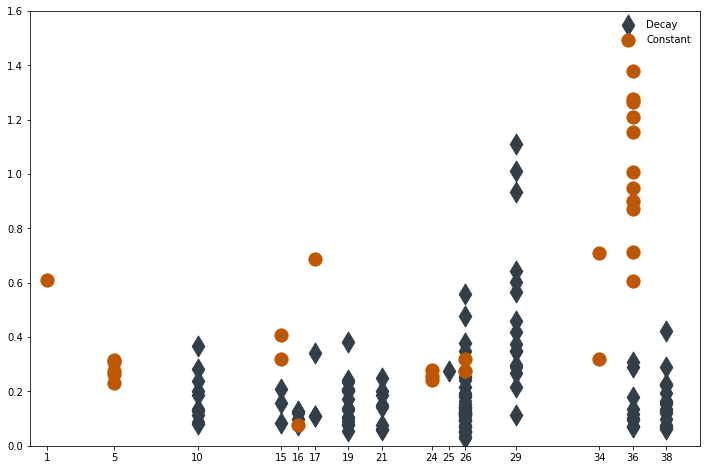

In [63]:
ventilation_estimates = decay_df[['beacon','beiwe','start','end','ach','method']].append(ventilation_df[['beacon','beiwe','start','end','ach','method']])
fig, ax = plt.subplots(figsize=(12,8))
#sns.stripplot(x='Beacon',y='ACH',color='#333f48',data=decay_df,s=15,jitter=0,marker='d',label='Decay')
#sns.stripplot(x='Beacon',y='ACH',color='#bf5700',data=ventilation_df,s=12,jitter=0,label='Constant')
ax.scatter(decay_df['beacon'],decay_df['ach'],s=220,color='#333f48',marker='d',label='Decay')
ax.scatter(ventilation_df['beacon'],ventilation_df['ach'],s=175,color='#bf5700',label='Constant')
ax.legend(frameon=False)
ax.set_ylim([0,1.6])
ax.set_xlim([0,40])
ax.set_xticks(ventilation_estimates['beacon'].unique())
#plt.savefig('../reports/conferences/ASHRAESummer_2020/ventilation_estimates.pdf')
plt.show()
plt.close()

### Saving

In [64]:
decay_df.to_csv("../data/processed/beacon-ventilation_from_decay.csv",index=False)
decay_df.head()

,beiwe,beacon,start,end,ending_co2_meas,ending_co2_calculated,rmsd,ach,ACH_EQ1,RMSD_EQ1,ACH_EQ3,RMSD_EQ3,ACH_EQ2,RMSD_EQ2,method
0,lkkjddam,21.0,2020-08-12 13:16:00,2020-08-12 13:38:00,2.420127,2.013373,0.243880,0.151,0.001,0.243880,0.109,0.022529,0.151,0.022275,decay
1,lkkjddam,21.0,2020-08-16 13:36:00,2020-08-16 14:08:00,2.022493,1.337421,0.402493,0.143,0.001,0.402493,0.096,0.013627,0.143,0.014344,decay
2,lkkjddam,21.0,2020-08-18 12:48:00,2020-08-18 13:22:00,2.600125,2.111837,0.250321,0.202,0.001,0.250321,0.152,0.047493,0.202,0.045182,decay
3,lkkjddam,21.0,2020-08-20 12:26:00,2020-08-20 12:52:00,3.123983,2.622436,0.337332,0.078,0.001,0.337332,0.061,0.041795,0.078,0.042002,decay
4,lkkjddam,21.0,2020-08-20 14:14:00,2020-08-20 14:44:00,2.837703,2.126034,0.433189,0.062,0.001,0.433189,0.047,0.019457,0.062,0.019535,decay


In [65]:
ventilation_df.to_csv("../data/processed/beacon-ventilation_from_ss.csv",index=False)
ventilation_df.head()

,beiwe,beacon,start,end,co2_mean,co2_delta,temperature_c_mean,temperature_c_delta,e,ach,method
0,kyj367pi,1.0,2020-07-20 23:14:00,2020-07-21 07:21:30,910.451565,0.167207,28.500000,0.000000,0.002631,0.608224,constant
0,e73a1pd5,16.0,2020-08-03 02:48:30,2020-08-03 08:25:00,4945.821223,0.759150,33.000000,0.000000,0.002890,0.074997,constant
0,745vq78e,5.0,2020-06-19 05:00:00,2020-06-19 12:27:30,1437.847169,1.515699,28.500556,-0.000556,0.002678,0.276791,constant
1,745vq78e,5.0,2020-06-20 05:32:00,2020-06-20 16:28:00,1488.172471,5.196086,28.000000,0.000000,0.002674,0.263552,constant
2,745vq78e,5.0,2020-06-26 05:57:30,2020-06-26 11:45:30,1648.169901,-0.807821,28.000000,0.000000,0.002674,0.229769,constant


In [66]:
ventilation_estimates.to_csv("../data/processed/beacon-ventilation.csv",index=False)
ventilation_estimates.head()

,beacon,beiwe,start,end,ach,method
0,21.0,lkkjddam,2020-08-12 13:16:00,2020-08-12 13:38:00,0.151,decay
1,21.0,lkkjddam,2020-08-16 13:36:00,2020-08-16 14:08:00,0.143,decay
2,21.0,lkkjddam,2020-08-18 12:48:00,2020-08-18 13:22:00,0.202,decay
3,21.0,lkkjddam,2020-08-20 12:26:00,2020-08-20 12:52:00,0.078,decay
4,21.0,lkkjddam,2020-08-20 14:14:00,2020-08-20 14:44:00,0.062,decay
